G27
Dave Brunner

In [248]:
import keras
import torch
from keras import Input
import tensorflow as tf
from keras.layers import Input, Conv2D, Activation, MaxPool2D, Flatten, Dense
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt

### Loading Data

In [249]:
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data() 
n_classes = 10
Y_train = keras.utils.to_categorical(y_train, n_classes)
Y_test = keras.utils.to_categorical(y_test, n_classes)

print(f"X_train shape: {X_train.shape}, y_train shape: {Y_train.shape}")

X_train shape: (60000, 28, 28), y_train shape: (60000, 10)


### CNN Baseline Model
Model with two CNN layers (including max pooling), one dense and an output classification layer, with suitable number of filters and units, respectively.

In [250]:
model = keras.Sequential([
    Input(shape=(28, 28, 1)),
    Conv2D(filters=32, strides=1, padding='same', kernel_size=4),
    Activation(activation='relu'),
    MaxPool2D(pool_size=2),
    Flatten(),
    Dense(10, activation='softmax'),
])
model_description = 'Input -> Conv2D filter=32,kernel_s=4, str=1-> ReLU -> MaxPool2D s=2 -> Flatten -> Dense -> Softmax'

In [251]:
model.summary()

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)              │ (None, 28, 28, 32)     │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_30 (Activation)      │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_30 (Flatten)            │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 10)             │        62,730 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,274 (247.16 KB)

 Trainable params: 63,274 (247.16 KB)

 Non-trainable params: 0 (0.00 B)

In [252]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


class Result:
    def __init__(self, network, epoch: int, batch_size: int, train_accuracy: [float], val_accuracy: [float],
                 train_loss: [float], val_loss: [float], cm: any):
        self.network = network,
        self.epoch = epoch,
        self.batch_size = batch_size
        self.train_loss = train_loss
        self.val_loss = val_loss
        self.train_accuracy = train_accuracy
        self.val_accuracy = val_accuracy
        self.cm = cm

    def __str__(self):
        return f'Network: {self.network}, Epochs: {self.epoch}, Batch size: {self.batch_size}, Final accuracy: [train:{self.train_accuracy[-1]}, val:{self.val_accuracy[-1]}] Final loss: [train:{self.train_loss[-1]}, val:{self.val_loss[-1]}'

    def title(self):
        return f'Network: {self.network}, Epochs: {self.epoch}, Batch: {self.batch_size}'

    def plot(self, plot_cm):
        f = plt.figure(figsize=(12, 4))
        ax1 = f.add_subplot(121)
        ax2 = f.add_subplot(122)
        ax1.plot(self.train_loss, label='Training loss')
        ax1.plot(self.val_loss, label='Validation loss')
        ax1.legend()
        ax1.grid()
        ax2.plot(self.train_accuracy, label='Training acc')
        ax2.plot(self.val_accuracy, label='Validation acc')
        ax2.legend()
        ax2.grid()
        if plot_cm:
            disp = ConfusionMatrixDisplay(confusion_matrix=cm)
            disp.plot(colorbar=False, cmap='Blues')
        plt.show()

    def plot_result(self, cm=False):
        print("--------------------------------------------")
        print(self.title())
        print(f"Final val accuracy: {self.val_accuracy[-1]}")
        self.plot(cm)

    def print_results(self):
        print("--------------------------------------------")
        print(self.title())
        print(f"Train accuracy: {self.train_accuracy[-1]}")
        print(f"Validation accuracy: {self.val_accuracy[-1]}")


results: [Result] = []

### Training

Implement the training / evaluation loop
Remember training / validation cost and accuracy per epoch and return them as list.

In [271]:
def train_eval(model: keras.Model, optimizer, nepochs, training_loader, validation_loader, scheduler=None, verbose=False):
    """
    Perform training and evaluation loop.
    :param model: Model to be trained
    :param optimizer: Optimiser to use for training
    :param nepochs: Number of epochs
    :param training_loader: Loader to provide mini-batches of training samples
    :param validation_loader: Loader to provide mini-batches of validation samples
    :param scheduler: Scheduler used for a learning rate schedule
    :return: Lists with training and validation cost and accuracy per epoch.
    """
    cost_hist = []
    cost_hist_val = []
    acc_hist = []
    acc_hist_val = []

    cost_ce = keras.losses.CategoricalCrossentropy()
    model.compile(loss=cost_ce, optimizer='adam', metrics=['accuracy'])

    for epoch in range(nepochs):
        acc, cost = 0, 0
        acc_val, cost_val = 0, 0
        batch_count = 0
       
        for (train_x, train_y), (val_x, val_y) in zip(training_loader.as_numpy_iterator(), validation_loader.as_numpy_iterator()):
            # Train on batch
            train_metrics = model.train_on_batch(train_x, train_y)
            cost += train_metrics[0]
            acc += train_metrics[1]

            # Validate on batch
            val_metrics = model.test_on_batch(val_x, val_y)
            cost_val += val_metrics[0]
            acc_val += val_metrics[1]
            batch_count += 1
            
        cost_hist.append(cost / batch_count)
        acc_hist.append(acc / batch_count)
        cost_hist_val.append(cost_val / batch_count)
        acc_hist_val.append(acc_val / batch_count)

            if verbose:
                print(f"Epoch {epoch + 1}")
                print(f"Train:      Accuracy={acc_hist[-1]:.4f}, Cost: {cost_hist[-1]:.4f}")
                print(f"Validation: Accuracy={acc_hist_val[-1]:.4f}, Cost: {cost_hist_val[-1]:.4f}")
                print("--------------------------------------")
        if not verbose:
            print(f"Final Validation Accuracy={acc_hist_val[-1]:.4f} Cost: {cost_hist_val[-1]:.4f}")
            print(f"Final Training   Accuracy={acc_hist[-1]:.4f} Cost: {cost_hist[-1]:.4f}")

    return cost_hist, cost_hist_val, acc_hist, acc_hist_val

2024-03-25 21:57:31.824752: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-25 21:58:41.479578: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


KeyboardInterrupt: 

In [264]:
n_epochs = 5
batch_size = 64
lr = 0.01
training_loader = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(batch_size)
validation_loader = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(batch_size)

optimizer = keras.optimizers.SGD(learning_rate=lr)
cost_hist, cost_hist_test, acc_hist, acc_hist_test = train_eval(model, optimizer, n_epochs, training_loader,
                                                                validation_loader, verbose=True)
results.append(Result(model_description, n_epochs, batch_size, acc_hist, acc_hist_test, cost_hist, cost_hist_test, None))

Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x140217100>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.12/3.12.2_1/Frameworks/Python.framework/Versions/3.12/lib/python3.12/weakref.py", line 369, in remove
    def remove(k, selfref=ref(self)):

KeyboardInterrupt: 
Exception ignored in: <function AtomicFunction.__del__ at 0x137e97420>
Traceback (most recent call last):
  File "/Users/davebrunner/.local/share/virtualenvs/TSM_DeLearn-xa9RRjL_/lib/python3.12/site-packages/tensorflow/python/eager/polymorphic_function/atomic_function.py", line 299, in __del__
    self._bound_context.remove_function(self.name)
  File "/Users/davebrunner/.local/share/virtualenvs/TSM_DeLearn-xa9RRjL_/lib/python3.12/site-packages/tensorflow/python/eager/context.py", line 1478, in remove_function
    pywrap_tfe.TFE_ContextRemoveFunction(self._handle, name)
KeyboardInterrupt: 


KeyboardInterrupt: 

### Train Baseline CNN Model

Follow the "Steps to Test and Tune a Model" as presented in the lecture.

Train the baseline with SGD without momentum and fixed learning rate. Tune the learning rate by this procedure.

Determine a suitable number of epochs.

### Overfit on small dataset to see if model is capable of learning

2024-03-25 21:54:35.523133: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-25 21:54:35.827526: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-25 21:54:36.134059: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-25 21:54:36.447036: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-25 21:54:36.755273: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-25 21:54:37.069854: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-25 21:54:37.389044: W tensorflow/core/framework/local_rendezvous.cc:404] L

Final Validation Accuracy=0.9213 Cost: 0.8235
Final Training   Accuracy=0.9223 Cost: 0.8123
--------------------------------------------
Network: ('Input -> Conv2D filter=32,kernel_s=4, str=1-> ReLU -> MaxPool2D s=2 -> Flatten -> Dense -> Softmax',), Epochs: (10,), Batch: 64
Final val accuracy: 0.9212839603424072


2024-03-25 21:54:38.352383: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


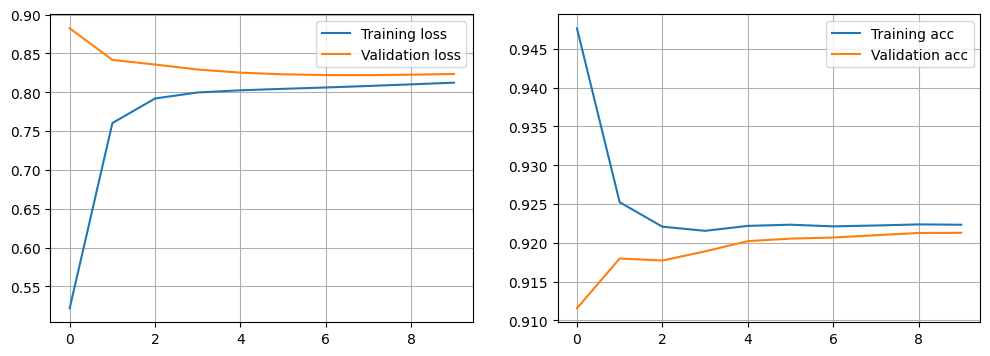

In [269]:
n_epochs = 10
batch_size = 64
sample_size = 250

lr = 0.01
training_loader = tf.data.Dataset.from_tensor_slices((X_train[:sample_size,:,:], Y_train[:sample_size])).batch(batch_size)
validation_loader = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(batch_size)

optimizer = keras.optimizers.SGD(learning_rate=lr)
cost_hist, cost_hist_test, acc_hist, acc_hist_test = train_eval(model, optimizer, n_epochs, training_loader,
                                                                validation_loader, verbose=False)
results.append(Result(model_description, n_epochs, batch_size, acc_hist, acc_hist_test, cost_hist, cost_hist_test, None))
results[-1].plot_result()

### Cross-Validation

Use 5-fold cross validation to estimate the accuracy and an error bar of the accuracy estimate.


### Analyse Different Optimisers with different Settings 

Use the code above to explore different settings for the different optimizers. Use batchsize 64.

1. *SGD*: Refer to the results from above - for later comparison.
<br>

2. *Momentum*: Play with at least three different settings when using momentum: learning rate, momentum parameter, Nesterov flag. Start with momentum=0.9 without Nesterov and suitable learning rate, then vary the momentum parameter and independently the learning rate. Can you see an impact of using Nesterov? What is your recommended best choice (lr, momentum, nesterov, nepochs) for the given problem?
<br>

3. *RMSProp*: Same thing now for RMSprop (without momentum). Play with at least three different settings when using RMSprop: lr, alpha. Start with the default settings of pytorch with (lr=0.01, alpha=0.99,centered=False). Then vary alpha and independently the learning rate. Can you see an impact when using centered=True? What is your recommended best choice (learning rate, alpha, centered, nepochs) for the given problem?<br>
<br>

4. *Adam*: Same thing now for Adam. Play with at least three different settings. Start with the default settings of pytorch. What is your recommended best choice for the given problem?<br>
<br>


In [257]:
nbatch = 64
nepochs =

training_loader = DataLoader(training_data, batch_size=nbatch, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=nbatch, shuffle=True)

model = mlp()
optimizer = ...
cost_hist, cost_hist_test, acc_hist, acc_hist_test = train_eval(model, optimizer, nepochs, training_loader,
                                                                validation_loader)


SyntaxError: invalid syntax (2706899016.py, line 2)

### Plots and Comments (for the different steps described above) 

### Learning Rate Schedule

Modify your `train_eval` method implemented above to support using a learning rate schedule for SGD (without momentum) - by using e.g. StepLR. What are your preferred settings for the given task?

Compare and evaluate the training performance with the results obtained for the different optimizers above and provide a judgement.